In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-coarsesn/best_model(7).pth
/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv
/kaggle/input/isic-2017/ISIC-2017_Validation_Part3_GroundTruth.csv
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0015129_segmentation.png
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0014743_segmentation.png
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0014233_segmentation.png
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0016001_segmentation.png
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0014647_segmentation.png
/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0013948_segmentation.png
/k

KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== MIF Module =====
class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv288 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv144 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv72 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv36 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x288 = x
        x144 = F.interpolate(x, size=(144, 144), mode='bilinear', align_corners=True)
        x72 = F.interpolate(x, size=(72, 72), mode='bilinear', align_corners=True)
        x36 = F.interpolate(x, size=(36, 36), mode='bilinear', align_corners=True)

        s288 = self.conv288(x288)
        s144 = self.conv144(x144)
        s72 = self.conv72(x72)
        s36 = self.conv36(x36)

        return s288, s144, s72, s36
# ===== Res2Block + SEBlock =====
class Res2Block(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4):
        super().__init__()
        assert in_channels % scale == 0
        self.scale = scale
        self.width = in_channels // scale

        self.conv1x1_in = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.width, self.width, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(self.width),
                nn.ReLU(inplace=True)
            ) for _ in range(scale - 1)
        ])

        self.conv1x1_out = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1x1_in(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]

        for i in range(1, self.scale):
            if i == 1:
                y = self.convs[i - 1](splits[i])
            else:
                y = self.convs[i - 1](splits[i] + outputs[-1])
            outputs.append(y)

        out = torch.cat(outputs, dim=1)
        out = self.conv1x1_out(out)
        out = self.bn_out(out)
        out += identity
        return self.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2SEBlock(nn.Module):
    def __init__(self, channels, dropout=0.3):
        super().__init__()
        self.res2 = Res2Block(channels, channels)
        self.se = SEBlock(channels)
        self.dropout = nn.Dropout2d(dropout)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.res2(x)
        out = self.se(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.relu(out)
        return out + identity
# ===== PDC Block =====
class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch2_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch2_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch3_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch4_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=8, dilation=8),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv4 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.fuse = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2_conv2(self.branch2_conv1(x))

        b3_1 = self.branch3_conv1(x)
        b3_2 = self.branch3_conv2(b3_1)
        b3 = self.branch3_conv3(b3_1 + b3_2)

        b4_1 = self.branch4_conv1(x)
        b4_2 = self.branch4_conv2(b4_1)
        b4_3 = self.branch4_conv3(b4_2 + b4_1)
        b4 = self.branch4_conv4(b4_3 + b4_2 + b4_1)

        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)
# ===== Final MRP_UNet Model =====
class MRP_UNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.mif = MIFModule()

        # Main encoder
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        # Side encoders (for MIF features)
        self.side_enc2 = Res2SEBlock(64)
        self.side_enc3 = Res2SEBlock(128)
        self.side_enc4 = Res2SEBlock(256)

        # Bottleneck
        self.bottleneck_pre = Res2SEBlock(512)
        self.pdc = PDCBlock(512, 512)
        self.bottleneck_post = Res2SEBlock(512)

        # Decoder
        self.dec4 = self.decoder_block(1024, 512, 256)
        self.dec3 = self.decoder_block(512, 256, 128)
        self.dec2 = self.decoder_block(256, 128, 64)
        self.dec1 = self.decoder_block(128, 64, 64)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def decoder_block(self, in_ch, mid_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):  # [B, 3, 288, 288]
        s288, s144, s72, s36 = self.mif(x)

        # Encoder
        e1 = self.enc1(s288)
        skip1 = e1
        x = F.max_pool2d(e1, 2)

        s144 = self.side_enc2(s144)
        x = torch.cat([x, s144], dim=1)
        e2 = self.enc2(x)
        skip2 = e2
        x = F.max_pool2d(e2, 2)

        s72 = self.side_enc3(s72)
        x = torch.cat([x, s72], dim=1)
        e3 = self.enc3(x)
        skip3 = e3
        x = F.max_pool2d(e3, 2)

        s36 = self.side_enc4(s36)
        x = torch.cat([x, s36], dim=1)
        e4 = self.enc4(x)
        skip4 = e4
        x = F.max_pool2d(e4, 2)

        # Bottleneck
        x = self.bottleneck_pre(x)
        x = self.pdc(x)
        x = self.bottleneck_post(x)

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip4], dim=1)
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)
        x = self.dec1(x)

        return self.final(x)  # [B, num_classes, 288, 288]


In [3]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Create output folder
os.makedirs("fine_masks", exist_ok=True)

# Image and mask directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
model_path = "/kaggle/input/best-coarsesn/best_model(7).pth"


In [4]:
class ISICDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_names = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.transform = transform or transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        return self.transform(img), img_name

    def __len__(self):
        return len(self.image_names)
dataset = ISICDataset(img_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
model = MRP_UNet(num_classes=2)
state_dict = torch.load(model_path, map_location='cuda')
model.load_state_dict(state_dict)
model.eval().cuda()


MRP_UNet(
  (mif): MIFModule(
    (conv288): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv144): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv72): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv36): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (enc1): Res2SEBlock(
    (res2): Res2Block(
      (conv1x1_in): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv1x1_out): Conv2d(64, 64, kernel_size=

100%|██████████| 2000/2000 [00:02<00:00, 697.05it/s]


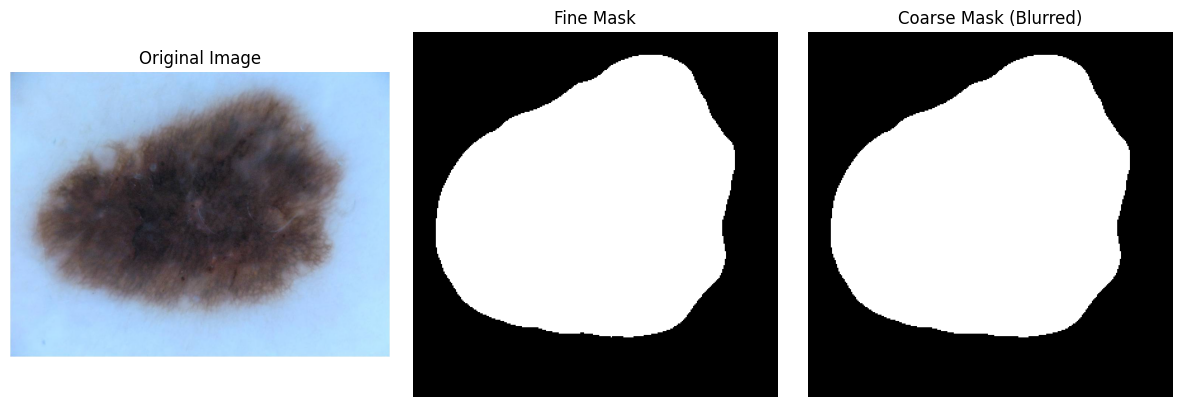

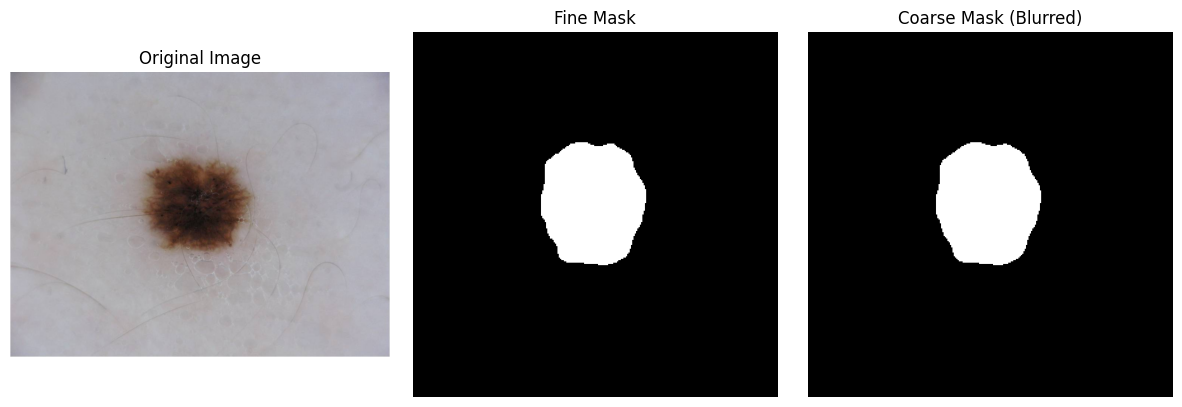

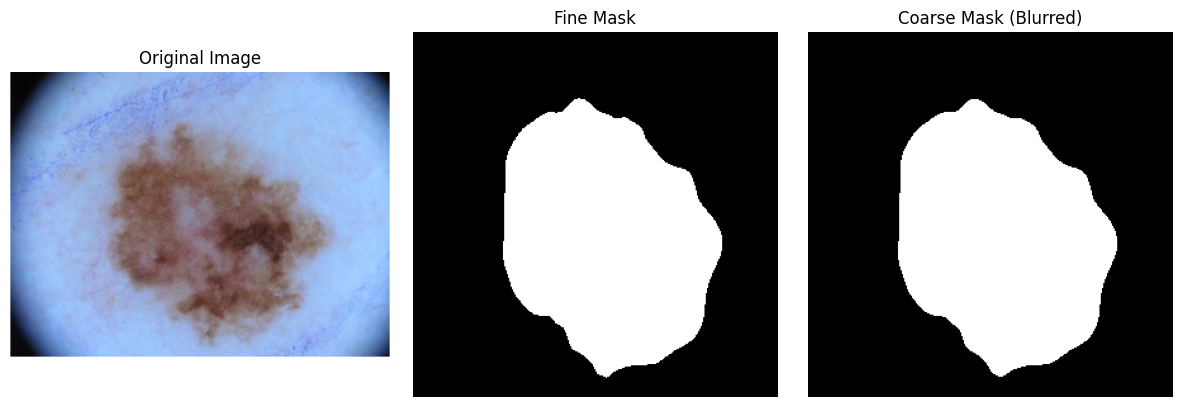

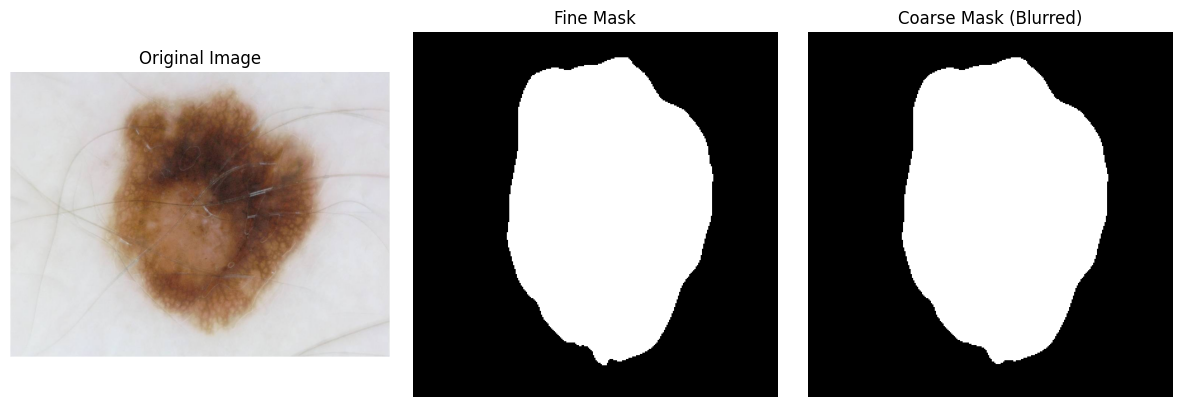

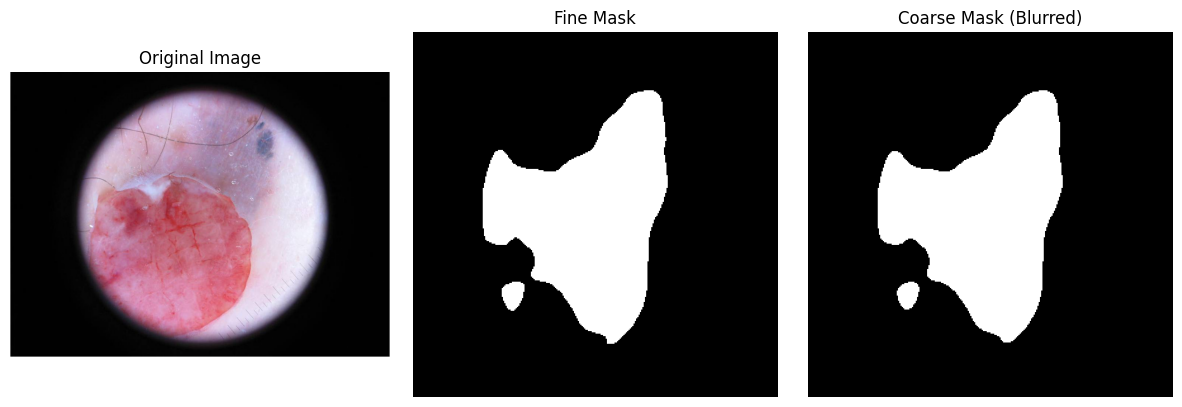

In [5]:
def save_mask(tensor, path):
    """Save binary mask (1-channel) as PNG"""
    mask = (tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)
    Image.fromarray(mask).save(path)

with torch.no_grad():
    for imgs, names in tqdm(dataloader):
        imgs = imgs.cuda()
        logits = model(imgs)               # [B, 2, H, W]
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)  # [B, H, W]

        for pred, name in zip(preds, names):
            out_path = f"fine_masks/{name.replace('.jpg', '.png')}"
            save_mask(pred.float(), out_path)
import cv2
import os
from tqdm import tqdm

input_dir = "fine_masks"
output_dir = "coarse_masks"
os.makedirs(output_dir, exist_ok=True)

def blur_and_binarize(input_path, output_path, kernel_size=15, threshold=127):
    """
    Applies Gaussian blur to a binary mask and saves the binarized result.
    """
    mask = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Failed to read {input_path}")
        return

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)

    # Binarize: threshold to remove soft edges
    _, binary_mask = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)

    cv2.imwrite(output_path, binary_mask)

# Apply to all fine masks
for fname in tqdm(os.listdir(input_dir)):
    if not fname.endswith(".png"):
        continue
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)
    blur_and_binarize(in_path, out_path)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
fine_dir = "fine_masks"
coarse_dir = "coarse_masks"

# Get a few sample filenames (change as needed)
sample_files = sorted([f for f in os.listdir(fine_dir) if f.endswith(".png")])[:5]

for fname in sample_files:
    # Load image and masks
    img_path = os.path.join(img_dir, fname.replace(".png", ".jpg"))
    fine_path = os.path.join(fine_dir, fname)
    coarse_path = os.path.join(coarse_dir, fname)

    # Load using PIL for RGB, OpenCV for masks
    image = np.array(Image.open(img_path).convert("RGB"))
    fine_mask = cv2.imread(fine_path, cv2.IMREAD_GRAYSCALE)
    coarse_mask = cv2.imread(coarse_path, cv2.IMREAD_GRAYSCALE)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(fine_mask, cmap="gray")
    plt.title("Fine Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(coarse_mask, cmap="gray")
    plt.title("Coarse Mask (Blurred)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv")

# Add 'filename' column
df["filename"] = df["image_id"] + ".jpg"

# Compute third class: nevus = 1 - MEL - SK
df["nevus"] = 1.0 - df["melanoma"] - df["seborrheic_keratosis"]

# Find dominant class
df["label"] = df[["melanoma", "nevus", "seborrheic_keratosis"]].idxmax(axis=1)

# Map class labels to numeric
class_map = {"melanoma": 0, "nevus": 1, "seborrheic_keratosis": 2}
df["label_idx"] = df["label"].map(class_map)

df.head()


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from tqdm import tqdm
from torchvision.utils import save_image

features_blobs = []

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        self.backbone = timm.create_model("legacy_xception", pretrained=True, num_classes=0, features_only=False)

        # Modify first conv layer for 4 channels
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1]  # duplicate channel
        
        # Final classifier head
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

        # Register CAM hook from final block
        self.backbone.global_pool.register_forward_hook(self._hook_feature)

    def _hook_feature(self, module, input, output):
        features_blobs.clear()
        features_blobs.append(input[0])  # Input to GAP is [B,C,H,W]

    def forward(self, x):
        feats = self.backbone(x)  # [B, num_features]
        out = self.classifier(feats)
        return out

def generate_cam(model, input_tensor, class_idx=None):
    model.eval()
    features_blobs.clear()
                            
    with torch.no_grad():
        logits = model(input_tensor.unsqueeze(0).to(next(model.parameters()).device))
        pred_idx = logits.argmax(dim=1).item() if class_idx is None else class_idx
        feature_map = features_blobs[0].squeeze(0)  # [C, H, W]
    
    weights = model.classifier.weight[pred_idx]  # [C]

    cam = torch.sum(weights[:, None, None] * feature_map, dim=0).detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam

def show_cam(input_tensor, cam, figsize=(12, 4)):
    rgb = input_tensor[:3].permute(1, 2, 0).cpu().numpy()
    rgb = (rgb - rgb.min()) / (rgb.max() + 1e-8)

    cam_resized = cv2.resize(cam, (rgb.shape[1], rgb.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * 0.5 + rgb * 0.5

    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1); plt.imshow(rgb); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(cam_resized, cmap='jet'); plt.title("CAM"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()
    plt.show()

def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
model.load_state_dict(torch.load("mask_cn1_best_val.pth"))
model.eval()
def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)
save_dir = "cam_heatmaps"
save_cams_for_dataset(model, train_dataset, save_dir, device)
save_cams_for_dataset(model, val_dataset, "cam_heatmaps_val", device)


Saving CAMs to: cam_heatmaps


100%|██████████| 1600/1600 [03:12<00:00,  8.30it/s]


Saving CAMs to: cam_heatmaps_val


100%|██████████| 200/200 [00:24<00:00,  8.15it/s]


In [ ]:
model.load_state_dict(torch.load("mask_cn_best_val.pth"))
model.eval()


In [7]:
# ===========================================
# ✅ 1️⃣ Imports
# ===========================================
import torch
import torch.nn as nn
import timm
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os

# ===========================================
# ✅ 2️⃣ Model (MaskCN)
# ===========================================
features_blobs = []

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        self.backbone = timm.create_model("legacy_xception", pretrained=True, num_classes=0)
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1]
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)
        self.backbone.global_pool.register_forward_hook(self._hook_feature)
    def _hook_feature(self, module, input, output):
        features_blobs.clear()
        features_blobs.append(input[0])
    def forward(self, x):
        feats = self.backbone(x)
        out = self.classifier(feats)
        return out

# ===========================================
# ✅ 3️⃣ Dataset class
# ===========================================
class MaskCNDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485]*4, std=[0.229]*4)
        ])
        self.resize = transforms.Resize((288, 288))
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row.filename)
        mask_path = os.path.join(self.mask_dir, row.filename.replace(".jpg", ".png"))
    
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
    
        img = self.resize(img)
        mask = self.resize(mask)
    
        img_np = np.array(img).astype("float32") / 255.0
        mask_np = np.expand_dims(np.array(mask).astype("float32") / 255.0, axis=-1)
    
        img4_np = np.concatenate([img_np, mask_np], axis=-1)
        img4_pil = Image.fromarray((img4_np * 255).astype("uint8"))
    
        img4_tensor = self.transform(img4_pil)
        label = torch.tensor(row.label_idx, dtype=torch.long)
        return img4_tensor, label

    def __len__(self):
        return len(self.df)

# ===========================================
# ✅ 4️⃣ Load training CSV + prepare DataFrame
# ===========================================
train_csv = "/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv"
df = pd.read_csv(train_csv)

# Add `filename` and `label_idx` columns if needed
df["filename"] = df["image_id"] + ".jpg"
df["label_idx"] = df["melanoma"] * 2 + df["seborrheic_keratosis"] * 1  # NV = 0, BKL = 1, MEL = 2

print(df.head())

# ===========================================
# ✅ 5️⃣ Split: 80-10-10 stratified
# ===========================================
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label_idx"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label_idx"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ===========================================
# ✅ 6️⃣ Datasets & Dataloaders
# ===========================================
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
mask_dir = "/kaggle/working/coarse_masks"

transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*4, std=[0.229]*4)
])

train_dataset = MaskCNDataset(train_df, image_dir, mask_dir, transform=transform)
val_dataset   = MaskCNDataset(val_df, image_dir, mask_dir, transform=transform)
test_dataset  = MaskCNDataset(test_df, image_dir, mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ===========================================
# ✅ 7️⃣ Class weights
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskCN(num_classes=3).to(device)

class_counts = np.bincount(df["label_idx"])
total = sum(class_counts)
class_weights = total / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

print("✅ Data ready.")


       image_id  melanoma  seborrheic_keratosis          filename  label_idx
0  ISIC_0000000       0.0                   0.0  ISIC_0000000.jpg        0.0
1  ISIC_0000001       0.0                   0.0  ISIC_0000001.jpg        0.0
2  ISIC_0000002       1.0                   0.0  ISIC_0000002.jpg        2.0
3  ISIC_0000003       0.0                   0.0  ISIC_0000003.jpg        0.0
4  ISIC_0000004       1.0                   0.0  ISIC_0000004.jpg        2.0
Train: 1600 | Val: 200 | Test: 200


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


✅ Data ready.


In [9]:
best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1:02d}] Training", leave=False)
    for imgs, labels in train_pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        train_pbar.set_postfix(loss=loss.item())

    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"[Epoch {epoch+1:02d}] Validation", leave=False)
        for imgs, labels in val_pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            val_pbar.set_postfix(loss=loss.item())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"\n[Epoch {epoch+1:02d}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(classification_report(val_labels, val_preds, target_names=["NV", "BKL", "MEL"]))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mask_cn1_best_val.pth")
        print("✅ Best model saved!")



[Epoch 01] Train Loss: 89.0502 | Train Acc: 0.6312 | Val Loss: 9.1478 | Val Acc: 0.6300
              precision    recall  f1-score   support

          NV       0.87      0.61      0.72       137
         BKL       0.39      1.00      0.56        25
         MEL       0.44      0.47      0.46        38

    accuracy                           0.63       200
   macro avg       0.57      0.69      0.58       200
weighted avg       0.73      0.63      0.65       200

✅ Best model saved!



[Epoch 02] Train Loss: 46.2756 | Train Acc: 0.8100 | Val Loss: 8.1646 | Val Acc: 0.7450
              precision    recall  f1-score   support

          NV       0.88      0.77      0.82       137
         BKL       0.62      0.84      0.71        25
         MEL       0.49      0.58      0.53        38

    accuracy                           0.74       200
   macro avg       0.66      0.73      0.69       200
weighted avg       0.77      0.74      0.75       200

✅ Best model saved!



[Epoch 03] Train Loss: 21.2438 | Train Acc: 0.9225 | Val Loss: 9.2245 | Val Acc: 0.7450
              precision    recall  f1-score   support

          NV       0.90      0.74      0.81       137
         BKL       0.75      0.72      0.73        25
         MEL       0.47      0.79      0.59        38

    accuracy                           0.74       200
   macro avg       0.71      0.75      0.71       200
weighted avg       0.80      0.74      0.76       200




[Epoch 04] Train Loss: 13.3248 | Train Acc: 0.9487 | Val Loss: 10.2275 | Val Acc: 0.7650
              precision    recall  f1-score   support

          NV       0.84      0.83      0.84       137
         BKL       0.76      0.76      0.76        25
         MEL       0.51      0.53      0.52        38

    accuracy                           0.77       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.77      0.77      0.77       200

✅ Best model saved!



[Epoch 05] Train Loss: 7.6210 | Train Acc: 0.9781 | Val Loss: 13.0636 | Val Acc: 0.7900
              precision    recall  f1-score   support

          NV       0.83      0.90      0.86       137
         BKL       0.89      0.68      0.77        25
         MEL       0.56      0.47      0.51        38

    accuracy                           0.79       200
   macro avg       0.76      0.68      0.72       200
weighted avg       0.78      0.79      0.78       200

✅ Best model saved!


In [11]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ===========================================
# ✅ Make sure model is defined exactly same
# ===========================================
# You already did that: MaskCN class ✅

# ===========================================
# ✅ Load best model weights
# ===========================================
model.load_state_dict(torch.load("/kaggle/working/mask_cn1_best_val.pth", map_location=device))
model.eval()

# ===========================================
# ✅ Run test inference on last 10%
# ===========================================
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Running Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# ===========================================
# ✅ Accuracy & Report
# ===========================================
acc = accuracy_score(test_labels, test_preds)
print(f"\n✅ FINAL TEST ACCURACY (last 10%): {acc:.4f}")

print("\n✅ CLASSIFICATION REPORT:")
print(classification_report(test_labels, test_preds, target_names=["NV", "BKL", "MEL"]))


Running Test: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


✅ FINAL TEST ACCURACY (last 10%): 0.7300

✅ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          NV       0.78      0.88      0.83       137
         BKL       0.62      0.50      0.55        26
         MEL       0.52      0.32      0.40        37

    accuracy                           0.73       200
   macro avg       0.64      0.57      0.59       200
weighted avg       0.71      0.73      0.71       200

